<a href="https://colab.research.google.com/github/YeolGwang/openknowl-TEST/blob/main/18_segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('./MyDrive')

In [ ]:
cd MyDrive/MyDrive/CV_exprt/SEG

[Errno 2] No such file or directory: 'MyDrive/MyDrive/CV_exprt/SEG'
/content


In [ ]:
pwd

'/content'

In [ ]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras



In [ ]:
# class : 특정 기능과 관련된 변수, 함수를 모아서 구성한 자료 구조
# __init__() : DataGen class 인스턴스 생성시, 자동적으로 호출되는 함수, 파라미터를 세팅
# __load__() : 이미지 id를 인자로 받아 image와 mask load하여 반환하는 함수 
# __getitem__() : 학습단위(batch size)로 data를 재구성

class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size = 8, image_size = 128):
        self.ids = ids
        self.path =path
        self.batch_size = batch_size
        self.image_size = image_size
        

    def __load__(self, id_name):
        image_path = os.path.join(self.path, id_name, "images", id_name)+".png"
        mask_path = os.path.join(self.path, id_name,"masks/")
        all_masks = os.listdir(mask_path)
        
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image.shape
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        for name in all_masks:
            _mask_path = mask_path+name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask= np.maximum(mask, _mask_image)
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    

    def __getitem__(self, index):
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]
        image=[]
        mask=[]
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image =np.array(image)
        mask = np.array(mask)
        
        return image, mask
        
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128
train_path="./data-science-bowl-2018/stage1_train/"
batch_size= 8

train_ids = next(os.walk(train_path))[1]
val_data_size = 10
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]



In [ ]:
gen = DataGen(train_ids, train_path, batch_size = batch_size, image_size= image_size)
x,y = gen.__getitem__(0)


# batchsize, width, height, channel
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


7
(128, 128, 3)


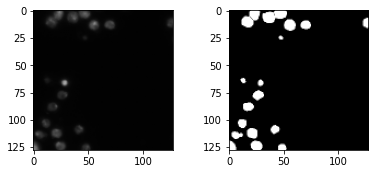

In [ ]:
r = random.randint(0, len(x)-1)
print(len(x)-1)
print(x[r].shape)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
def down_block(x,filters, kernel_size=(3,3), padding ="same", strides = 1):
    
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
    
    p = keras.layers.MaxPool2D((2,2), (2,2))(c)
    
    return c, p

def up_block(x, skip, filters, kernel_size= (3,3), padding= "same", strides = 1 ):
    us = keras.layers.UpSampling2D((2,2))(x)
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
    return c

def bottleneck(x,filters, kernel_size=(3,3), padding ="same", strides = 1):
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
    return c
    

In [ ]:
def UNet():
    f = [16,32,64,128, 256]
    inputs =keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16 -> 8
    
    bn = bottleneck(p4,f[4])
    
    u1=up_block(bn, c4, f[3]) # 8->16
    u2=up_block(u1, c3, f[2]) # 16->32
    u3=up_block(u2, c2, f[1]) # 32->64
    u4=up_block(u3, c1, f[0]) # 64->127
    
    outputs = keras.layers.Conv2D(1,(1,1), padding = "same", activation="sigmoid")(u4)
    
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["acc"])
model.summary()

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size =image_size, batch_size = batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size =image_size, batch_size = batch_size)

train_steps = len(train_ids)//batch_size
valid_steps= len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch= train_steps, validation_steps=valid_steps, epochs = 1)

81/82 [============================>.] - ETA: 3s - loss: 0.3572 - acc: 0.8466
Epoch 00001: val_loss improved from inf to 0.36545, saving model to mymodel_1.h5
82/82 [==============================] - 257s 3s/step - loss: 0.3546 - acc: 0.8474 - val_loss: 0.3654 - val_acc: 0.8186


In [ ]:

x,y = valid_gen.__getitem__(1)
result = model.predict(x)
result = result>0.5

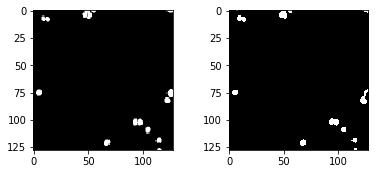

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

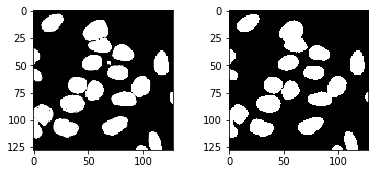

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [ ]:
model.save('seg.h5')

In [ ]:

loaded_model=keras.models.load_model('seg.h5')

loaded_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["acc"])
loaded_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
x,y = valid_gen.__getitem__(1)
result = loaded_model.predict(x)

result = result>0.5

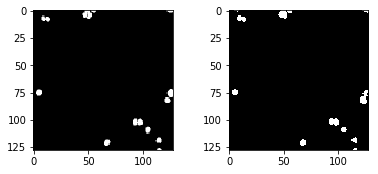

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")